1. Analyzing trends over time in the issuance of notices, focusing on variables like department, type, and geographical distribution. 

In [1]:
from pyspark.sql import SparkSession

# Initialize a SparkSession
spark = SparkSession.builder \
    .appName("Notice Trend Analysis") \
    .getOrCreate()

In [2]:
# Load the dataset
file_path = "FY2023_archived_opportunities.csv"  # Replace with your file path
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the dataframe structure
df.printSchema()

root
 |-- NoticeId: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Sol#: string (nullable = true)
 |-- Department/Ind.Agency: string (nullable = true)
 |-- CGAC: string (nullable = true)
 |-- Sub-Tier: string (nullable = true)
 |-- FPDS Code: string (nullable = true)
 |-- Office: string (nullable = true)
 |-- AAC Code: string (nullable = true)
 |-- PostedDate: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- BaseType: string (nullable = true)
 |-- ArchiveType: string (nullable = true)
 |-- ArchiveDate: string (nullable = true)
 |-- SetASideCode: string (nullable = true)
 |-- SetASide: string (nullable = true)
 |-- ResponseDeadLine: string (nullable = true)
 |-- NaicsCode: string (nullable = true)
 |-- ClassificationCode: string (nullable = true)
 |-- PopStreetAddress: string (nullable = true)
 |-- PopCity: string (nullable = true)
 |-- PopState: string (nullable = true)
 |-- PopZip: string (nullable = true)
 |-- PopCountry: string (nullable = true)


In [3]:
df.select("PostedDate").show(truncate=False)

+--------------------------+
|PostedDate                |
+--------------------------+
|2023-09-30 23:56:44.565-04|
|2023-09-30 23:07:36.23-04 |
|2023-09-30 22:21:30.035-04|
|2023-09-30 21:31:26.359-04|
|2023-09-30 20:38:13.619-04|
|2023-09-30 20:27:28.931-04|
|2023-09-30 20:15:19.313-04|
|2023-09-30 20:09:01.128-04|
|2023-09-30 20:05:00.737-04|
|2023-09-30 19:24:35.752-04|
|2023-09-30 19:20:12.252-04|
|2023-09-30 19:06:01.113-04|
|2023-09-30 18:54:36.272-04|
|2023-09-30 18:53:33.321-04|
|2023-09-30 18:43:31.706-04|
|2023-09-30 18:42:45.957-04|
|2023-09-30 18:33:37.533-04|
|2023-09-30 18:31:02.564-04|
|2023-09-30 18:30:03.176-04|
|2023-09-30 18:27:23.07-04 |
+--------------------------+
only showing top 20 rows



In [4]:
from pyspark.sql.functions import col, to_date, month

# Convert string date to date type
df = df.withColumn("PostedMonth", month("PostedDate"))

df = df.withColumnRenamed("Department/Ind.Agency", "Department_Ind_Agency")

# Select relevant columns
trends_df = df.select(
    col("PostedDate"),
    col("Department_Ind_Agency"),
    col("Type"),
    col("PopState"),
    col("PostedMonth")
)


In [5]:
trends_df.show()

+--------------------+---------------------+--------------------+--------+-----------+
|          PostedDate|Department_Ind_Agency|                Type|PopState|PostedMonth|
+--------------------+---------------------+--------------------+--------+-----------+
|2023-09-30 23:56:...|      DEPT OF DEFENSE|        Award Notice|      MI|          9|
|2023-09-30 23:07:...|      DEPT OF DEFENSE|        Award Notice|    NULL|          9|
|2023-09-30 22:21:...|      DEPT OF DEFENSE|        Award Notice|    NULL|          9|
|2023-09-30 21:31:...|      DEPT OF DEFENSE|Combined Synopsis...|      HI|          9|
|2023-09-30 20:38:...|      DEPT OF DEFENSE|        Award Notice|      CA|          9|
|2023-09-30 20:27:...|      DEPT OF DEFENSE|        Award Notice|      MS|          9|
|2023-09-30 20:15:...|      DEPT OF DEFENSE|        Award Notice|      VA|          9|
|2023-09-30 20:09:...|      DEPT OF DEFENSE|        Solicitation|      CO|          9|
|2023-09-30 20:05:...|      DEPT OF DEFENSE

In [6]:
unique_values = trends_df.select("PostedMonth").distinct()
unique_values.show(truncate=False)

+-----------+
|PostedMonth|
+-----------+
|9          |
|8          |
|1          |
|7          |
|6          |
|5          |
|4          |
|3          |
|2          |
|12         |
|11         |
|10         |
|NULL       |
+-----------+



In [7]:
trends_df=trends_df.na.drop()

In [8]:
unique_values = trends_df.select("PostedMonth").distinct()
unique_values.show(truncate=False)

+-----------+
|PostedMonth|
+-----------+
|9          |
|8          |
|1          |
|7          |
|6          |
|5          |
|4          |
|3          |
|2          |
|12         |
|11         |
|10         |
+-----------+



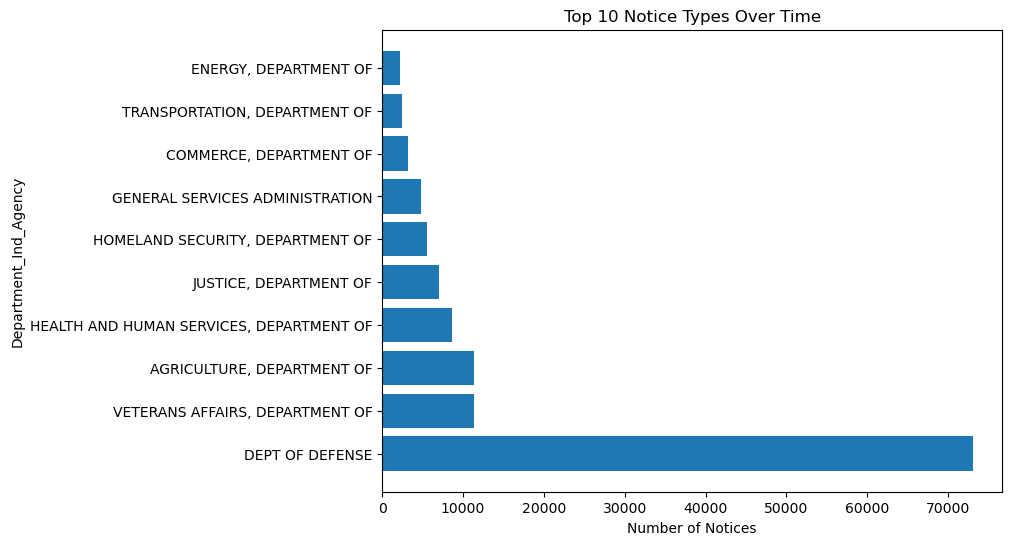

In [9]:
from pyspark.sql.functions import count, desc
import matplotlib.pyplot as plt

# Count notices by department over time
dept_trends = trends_df.groupBy("Department_Ind_Agency").agg(count("*").alias("NoticeCount"))
dept_trends = dept_trends.orderBy(desc("NoticeCount"))

# Show the top 10 records
top_10_dept = dept_trends.limit(10)

# Convert PySpark DataFrame to Pandas DataFrame for local plotting
top_10_dept_pd = top_10_dept.toPandas()

# Plotting the horizontal bar Type Vs No. of notices
plt.figure(figsize=(8, 6))
plt.barh(top_10_dept_pd['Department_Ind_Agency'], top_10_dept_pd['NoticeCount'])

# Labeling the plot, x-axis, and y-axis
plt.title('Top 10 Notice Types Over Time')
plt.xlabel('Number of Notices')
plt.ylabel('Department_Ind_Agency')

plt.show()

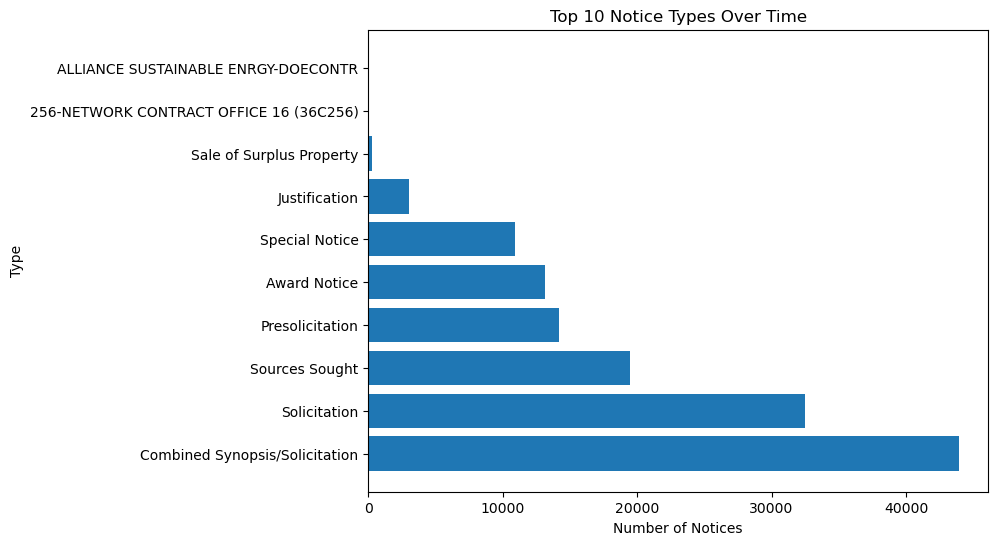

In [10]:
# Count notices by type over time
type_trends = trends_df.groupBy("Type").agg(count("*").alias("NoticeCount"))
type_trends = type_trends.orderBy(desc("NoticeCount"))

# Show the top 10 records
top_10_types = type_trends.limit(10)

# Convert PySpark DataFrame to Pandas DataFrame for local plotting
top_10_types_pd = top_10_types.toPandas()

# Plotting the horizontal bar Type Vs No. of notices
plt.figure(figsize=(8, 6))
plt.barh(top_10_types_pd['Type'], top_10_types_pd['NoticeCount'])

# Labeling the plot, x-axis, and y-axis
plt.title('Top 10 Notice Types Over Time')
plt.xlabel('Number of Notices')
plt.ylabel('Type')

plt.show()


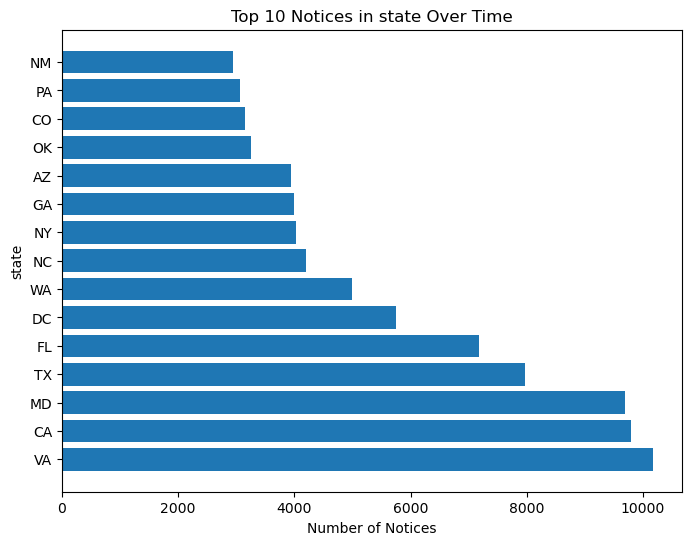

In [11]:
# Count notices by state over time
state_trends = trends_df.groupBy("PopState").agg(count("*").alias("NoticeCount"))
state_trends = state_trends.orderBy(desc("NoticeCount"))

# Show the top 10 records
top_10_state = state_trends.limit(15)

# Convert PySpark DataFrame to Pandas DataFrame for local plotting
top_10_state_pd = top_10_state.toPandas()

# Plotting the horizontal bar Type Vs No. of notices
plt.figure(figsize=(8, 6))
plt.barh(top_10_state_pd['PopState'], top_10_state_pd['NoticeCount'])

# Labeling the plot, x-axis, and y-axis
plt.title('Top 10 Notices in state Over Time')
plt.xlabel('Number of Notices')
plt.ylabel('state')

plt.show()

In [12]:
#Identifying Patterns or Anomalies (Optional Advanced Analysis)

from pyspark.sql.window import Window
from pyspark.sql.functions import avg

# Define a window spec
windowSpec = Window.partitionBy("Department_Ind_Agency").rowsBetween(-7, 0)

# Calculate the rolling average
dept_trends = dept_trends.withColumn("RollingAvg", avg("NoticeCount").over(windowSpec))

# Identify days with high deviation from the rolling average
dept_trends = dept_trends.withColumn("Deviation", (dept_trends["NoticeCount"] - dept_trends["RollingAvg"]))
dept_trends.filter(dept_trends["Deviation"] > 2)  # Set an appropriate threshold


DataFrame[Department_Ind_Agency: string, NoticeCount: bigint, RollingAvg: double, Deviation: double]

2. Departmental Spending Analysis: Leverage the financial columns (like Award$, AwardDate) to analyze spending patterns across different departments or agencies. Spark's ability to handle large datasets can be utilized to process and aggregate financial data to uncover insights into spending trends or anomalies.

In [13]:
#Select relevant columns
spending_df = df.select(
    col("AwardDate"),
    col("Department_Ind_Agency"),
    col("Award$"),
    col("PostedMonth")
)

In [14]:
# Preprocess the Data
from pyspark.sql.functions import col, to_date

# Convert string date to date type and ensure Award$ is a numeric type
spending_df = spending_df.withColumn("AwardDate", to_date(col("AwardDate"), "yyyy-MM-dd"))
spending_df = spending_df.withColumn("Award$", df["Award$"].cast("float"))

# Filtering out rows with null values in critical columns
spending_df = spending_df.filter(spending_df["Award$"].isNotNull() & spending_df["AwardDate"].isNotNull() & spending_df["Department_Ind_Agency"].isNotNull())


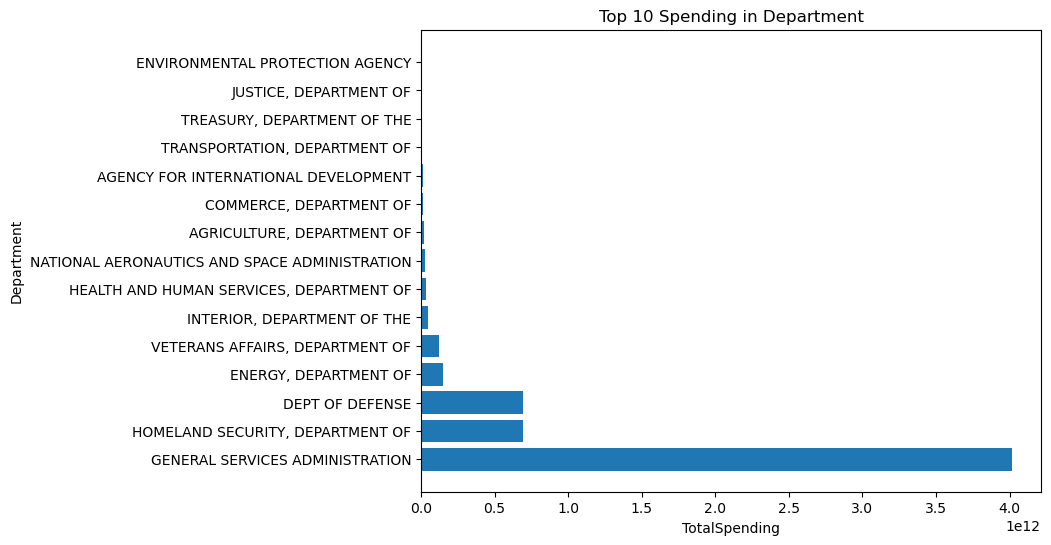

In [15]:
#Aggregate Spending by Department
from pyspark.sql.functions import sum

# Aggregate total spending by department
dept_spending = spending_df.groupBy("Department_Ind_Agency").agg(sum("Award$").alias("TotalSpending"))

# Order by total spending
dept_spending = dept_spending.orderBy("TotalSpending", ascending=False)

# Show the top 10 records
top_10_dept_spending = dept_spending.limit(15)

# Convert PySpark DataFrame to Pandas DataFrame for local plotting
top_10_dept_spending_pd = top_10_dept_spending.toPandas()

# Plotting the horizontal bar Type Vs No. of notices
plt.figure(figsize=(8, 6))
plt.barh(top_10_dept_spending_pd['Department_Ind_Agency'], top_10_dept_spending_pd['TotalSpending'])

# Labeling the plot, x-axis, and y-axis
plt.title('Top 10 Spending in Department')
plt.xlabel('TotalSpending')
plt.ylabel('Department')

plt.show()


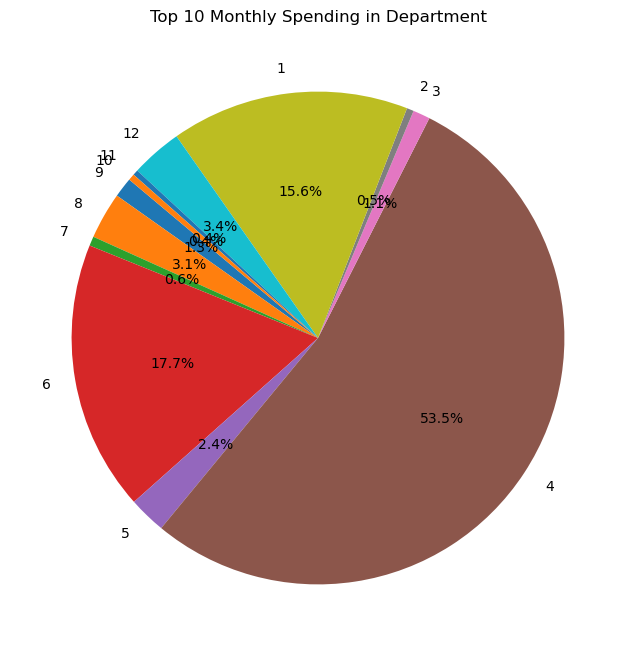

In [16]:
# Filter data for General Services Administration
gsa_spending = spending_df.filter(col("Department_Ind_Agency") == 'General Services Administration')

# Aggregate total spending by department
monthly_spending = spending_df.groupBy("PostedMonth").agg(sum("Award$").alias("TotalSpending"))

# Order by total spending
#monthly_spending = monthly_spending.orderBy("TotalSpending", ascending=False)

# Convert PySpark DataFrame to Pandas DataFrame for local plotting
monthly_spending_pd = monthly_spending.toPandas()

# Plotting a pie chart for the top 10 monthly spending
plt.figure(figsize=(8, 8))
plt.pie(monthly_spending_pd['TotalSpending'], labels=monthly_spending_pd['PostedMonth'], autopct='%1.1f%%', startangle=140)

# Labeling the plot
plt.title('Top 10 Monthly Spending in Department')

plt.show()

3. Geographical Analysis of Awards: Use location-based data (PopCity, PopState, CountryCode) to perform a geographical analysis of where awards are being distributed. This can involve mapping the data and using Spark's capabilities to handle geospatial data for insights into regional disparities or concentrations. 

In [17]:
Geographical_df = df.select(
    col("AwardDate"),
    col("Award$"),
    col("PopCity"),
    col("PopState"),
    col("CountryCode")
)

In [18]:
from pyspark.sql.functions import col

# Convert Award$ to a numeric type and ensure location columns are not null
df = df.withColumn("Award$", df["Award$"].cast("float"))
df = df.filter(df["Award$"].isNotNull() & df["PopCity"].isNotNull() & df["PopState"].isNotNull() & df["CountryCode"].isNotNull())


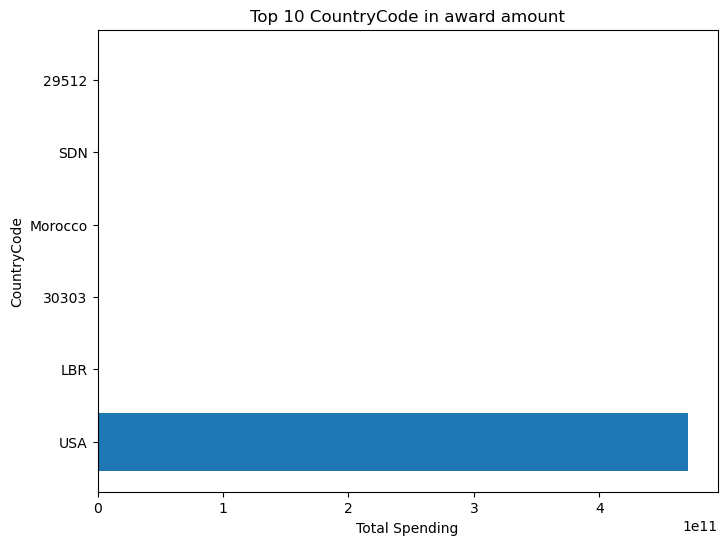

In [19]:
# Aggregate total awards by country
country_awards = df.groupBy("CountryCode").agg(sum("Award$").alias("TotalAwardAmount"))

# Order by total awards
country_awards = country_awards.orderBy("TotalAwardAmount", ascending=False)

# Show the top 10 records
top_10_country_awards = country_awards.limit(15)

# Convert PySpark DataFrame to Pandas DataFrame for local plotting
top_10_country_awards_pd = top_10_country_awards.toPandas()

# Plotting the horizontal bar Type Vs No. of notices
plt.figure(figsize=(8, 6))
plt.barh(top_10_country_awards_pd['CountryCode'], top_10_country_awards_pd['TotalAwardAmount'])

# Labeling the plot, x-axis, and y-axis
plt.title('Top 10 CountryCode in award amount')
plt.xlabel('Total Spending')
plt.ylabel('CountryCode')

plt.show()


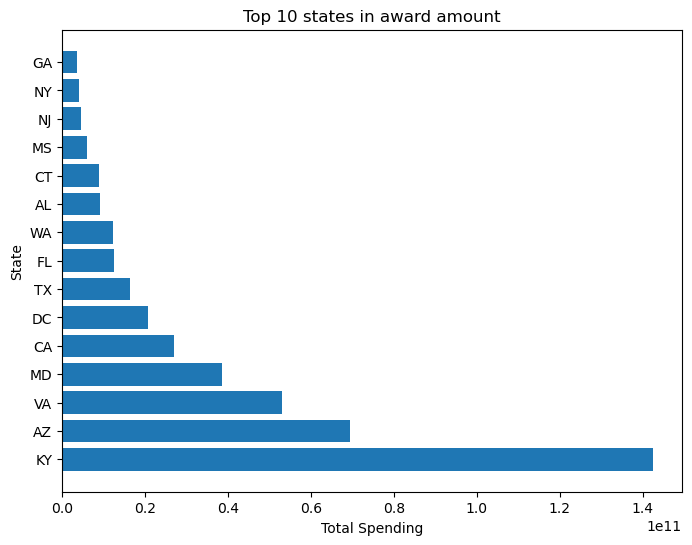

In [20]:
# Aggregate total awards by state
state_awards = df.groupBy("PopState").agg(sum("Award$").alias("TotalAwardAmount"))

# Order by total awards
state_awards = state_awards.orderBy("TotalAwardAmount", ascending=False)

# Show the top 10 records
top_10_state_awards = state_awards.limit(15)

# Convert PySpark DataFrame to Pandas DataFrame for local plotting
top_10_state_awards_pd = top_10_state_awards.toPandas()

# Plotting the horizontal bar Type Vs No. of notices
plt.figure(figsize=(8, 6))
plt.barh(top_10_state_awards_pd['PopState'], top_10_state_awards_pd['TotalAwardAmount'])

# Labeling the plot, x-axis, and y-axis
plt.title('Top 10 states in award amount')
plt.xlabel('Total Spending')
plt.ylabel('State')

plt.show()


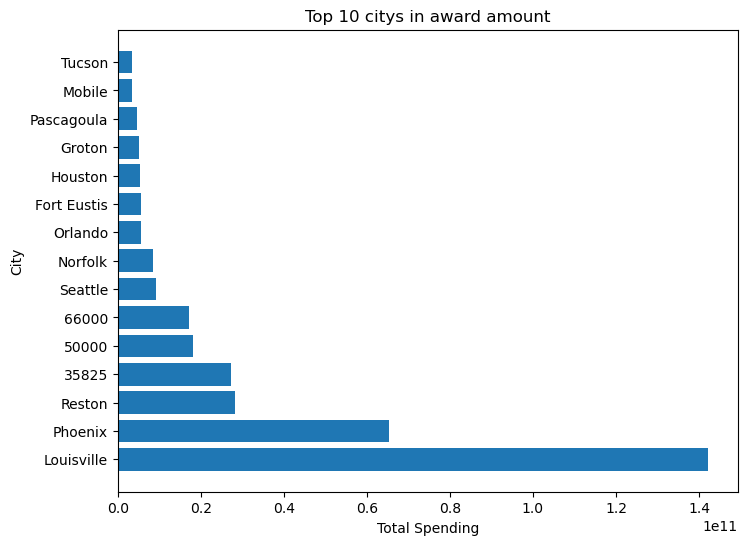

In [21]:
from pyspark.sql.functions import sum

# Aggregate total awards by city
city_awards = df.groupBy("PopCity").agg(sum("Award$").alias("TotalAwardAmount"))

# Order by total awards
city_awards = city_awards.orderBy("TotalAwardAmount", ascending=False)

# Show the top 10 records
top_10_city_awards = city_awards.limit(15)

# Convert PySpark DataFrame to Pandas DataFrame for local plotting
top_10_city_awards_pd = top_10_city_awards.toPandas()

# Plotting the horizontal bar Type Vs No. of notices
plt.figure(figsize=(8, 6))
plt.barh(top_10_city_awards_pd['PopCity'], top_10_city_awards_pd['TotalAwardAmount'])

# Labeling the plot, x-axis, and y-axis
plt.title('Top 10 citys in award amount')
plt.xlabel('Total Spending')
plt.ylabel('City')

plt.show()


4. Predictive Modeling for Award Amounts: Use the historical data to build predictive models for future award amounts (Award$). This could involve using Spark's machine learning libraries to predict the size of awards based on factors like department, NAICS code, and location. give detailed pyspark code

In [22]:
#Data Preprocessing
from pyspark.sql.functions import col

# Select relevant columns and drop rows with missing values
selected_columns = ["Department_Ind_Agency", "NaicsCode", "PopState", "Award$"]
df = df.select(*selected_columns).na.drop()

In [23]:
#Transform categorical variables into numerical using One-Hot Encoding and assemble all features into a single vector.
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Indexing categorical columns
indexers = [
    StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) 
    for column in ["Department_Ind_Agency", "NaicsCode", "PopState"]
]

# Encoding indexed columns
encoders = [
    OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=indexer.getOutputCol()+"_enc") 
    for indexer in indexers
]

# Assemble the encoded features
assembler = VectorAssembler(
    inputCols=[encoder.getOutputCol() for encoder in encoders],
    outputCol="features"
)

# Apply transformations
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])
df_transformed = pipeline.fit(df).transform(df)

(train_data, test_data) = df_transformed.randomSplit([0.8, 0.2], seed=1234)


In [24]:
#Model training 
from pyspark.ml.regression import LinearRegression

# Define the model
lr = LinearRegression(featuresCol='features', labelCol='Award$')

# Train the model
lr_model = lr.fit(train_data)


In [25]:
from pyspark.ml.evaluation import RegressionEvaluator

# Predict on train data
train_predictions = lr_model.transform(train_data)

# Predict on test data
test_predictions = lr_model.transform(test_data)

# Evaluate the model using R-squared
evaluator = RegressionEvaluator(labelCol="Award$", predictionCol="prediction", metricName="r2")

# R-squared on train data
train_r2 = evaluator.evaluate(train_predictions)
print("R-squared on train data =", train_r2)

# R-squared on test data
test_r2 = evaluator.evaluate(test_predictions)
print("R-squared on test data =", test_r2)


R-squared on train data = 0.9643794660399894
R-squared on test data = 0.9724955314548248


In [26]:
from pyspark.ml.regression import DecisionTreeRegressor

# Create a DecisionTreeRegressor model
dt_model = DecisionTreeRegressor(featuresCol='features', labelCol='Award$')

# Train the model
model = dt_model.fit(train_data)

# Make predictions on the test set
test_predictions = model.transform(test_data)

# Predict on train data
train_predictions = model.transform(train_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol='Award$', predictionCol='prediction', metricName='r2')

test_rmse = evaluator.evaluate(test_predictions)
print(f'Root Mean Squared Error test(RMSE): {test_rmse}')

train_rmse = evaluator.evaluate(train_predictions)
print(f'Root Mean Squared Error train(RMSE): {train_rmse}')

# R-squared on train data
train_r2 = evaluator.evaluate(train_predictions)
print("R-squared on train data =", train_r2)

# R-squared on test data
test_r2 = evaluator.evaluate(test_predictions)
print("R-squared on test data =", test_r2)

Root Mean Squared Error test(RMSE): 0.9707581921662933
Root Mean Squared Error train(RMSE): 0.9771638552216855
R-squared on train data = 0.9771638552216855
R-squared on test data = 0.9707581921662933


In [27]:
from pyspark.ml.regression import RandomForestRegressor

# Create a RandomForestRegressor model
rf_model = RandomForestRegressor(featuresCol='features', labelCol='Award$', numTrees=100)

# Train the model
model = rf_model.fit(train_data)

# Make predictions on the test set
test_predictions = model.transform(test_data)

# Predict on train data
train_predictions = model.transform(train_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol='Award$', predictionCol='prediction', metricName='r2')

test_rmse = evaluator.evaluate(test_predictions)
print(f'Root Mean Squared Error test(RMSE): {test_rmse}')

train_rmse = evaluator.evaluate(train_predictions)
print(f'Root Mean Squared Error train(RMSE): {train_rmse}')

# R-squared on train data
train_r2 = evaluator.evaluate(train_predictions)
print("R-squared on train data =", train_r2)

# R-squared on test data
test_r2 = evaluator.evaluate(test_predictions)
print("R-squared on test data =", test_r2)

Root Mean Squared Error test(RMSE): 0.8011389612516043
Root Mean Squared Error train(RMSE): 0.8082533511175867
R-squared on train data = 0.8082533511175867
R-squared on test data = 0.8011389612516043
